In [1]:
import traceback
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from matplotlib.ticker import FuncFormatter

import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
# seaborn settings, research paper style, and palette
sns.set_context("paper")
sns.set_palette("husl")

In [3]:
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

def get_latest_event_file(event_dir):
    event_files = os.listdir(event_dir)
    event_files.sort(key=lambda f: os.path.getmtime(os.path.join(event_dir, f)))
    return event_files[-1]

# Extraction function
def tflog2pandas(path):
    runlog_data = pd.DataFrame({"metric": [], "value": [], "smth_value": [], "step": []})
    try:
        event_acc = EventAccumulator(path + "/" + get_latest_event_file(path))
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            smoothed_values = smooth(values, 0.5)
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "smth_value": smoothed_values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data

# Baseline Policy Runs

In [4]:
# load logs
tag_maps_s = {
    "bc_policy": "BC",
    "dqn_base_policy": "DQN",
    "ppo_base_policy": "PPO",
    "hrl_bc_ppo_policy_ws_mlp_dyn_clip": "HRL MLP",
    "hrl_bc_ppo_policy_ws_feat_dyn_clip": "HRL FEAT",
    "hrl_bc_ppo_policy_ws_all_dyn_clip": "HRL ALL",
}

tag_maps = {
    "stochastic": tag_maps_s,
}

dfs = {}
for _main_tag, _tag_map in tag_maps.items():
    holder = list()
    for tag, tag_name in _tag_map.items():
        df = pd.read_csv(f"runs/policy_runs/run_{tag}_stochastic_log.csv")
        df['tag'] = tag
        df['tag_name'] = tag_name
        holder.append(df)

    df_logs = pd.concat(holder)
    dfs[_main_tag] = df_logs

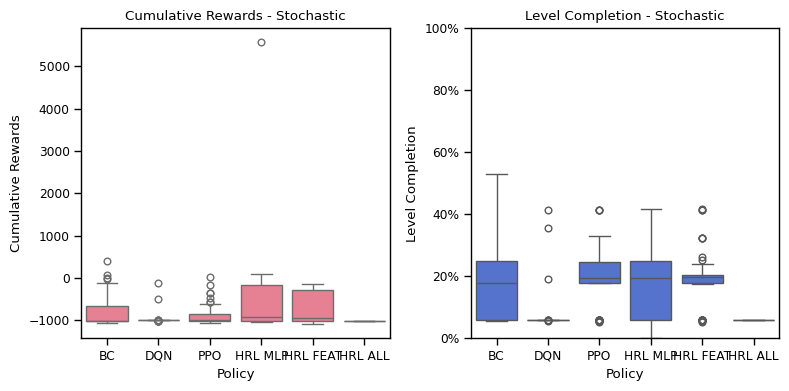

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes = axes.flatten()

# =================================================================================
# stochastic
df_logs = dfs["stochastic"]
orders = list(tag_maps['stochastic'].values())
sns.boxplot(data=df_logs, x='tag_name', y='cum_rewards', order=orders, ax=axes[0])
axes[0].set_xlabel("Policy")
axes[0].set_ylabel("Cumulative Rewards")
axes[0].set_title("Cumulative Rewards - Stochastic")

sns.boxplot(data=df_logs, x='tag_name', y='completion', order=orders, ax=axes[1], color="royalblue")
axes[1].set_xlabel("Policy")
axes[1].set_ylabel("Level Completion")
axes[1].set_title("Level Completion - Stochastic")
axes[1].set_ylim(0, 1)

# Change y-axis to percentage format
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.tight_layout()
# plt.savefig("../project_milestone/figures/cum_rewards_and_completion_baseline.png", dpi=300, bbox_inches='tight')

# Getting HRL_V1 Performance

In [97]:
experiments = {
    "baseline/ppo_base_policy": "PPO Baseline",
    "hrl_1/hrl_bc_ppo_policy_ws_mlp_dyn_clip": "HRL1-MLP",
    "hrl_1/hrl_bc_ppo_policy_ws_feat_dyn_clip": "HRL1-FEAT",
    "hrl_1/hrl_bc_ppo_policy_ws_all_dyn_clip": "HRL1-ALL",
}

data_holders = []
for exp in experiments.keys():
    path = f"runs/{exp}/PPO_1"
    data = tflog2pandas(path)
    data["exp"] = exp
    data["label"] = experiments[exp]
    data_holders.append(data)

df = pd.concat(data_holders)

In [62]:
df["metric"].unique()

array(['time/fps', 'train/approx_kl', 'train/clip_fraction',
       'train/clip_range', 'train/entropy_loss',
       'train/explained_variance', 'train/learning_rate', 'train/loss',
       'train/policy_gradient_loss', 'train/value_loss',
       'train/mean_episode_reward', 'train/std_episode_reward'],
      dtype=object)

In [63]:
tmp = pd.pivot_table(
    df[df["metric"].isin(["train/mean_episode_reward", "train/std_episode_reward"])], 
    index=["exp", "step"], 
    values="smth_value", 
    columns="metric"
).reset_index()
tmp["train/mean_episode_reward"] = tmp["train/mean_episode_reward"]

In [64]:
tmp.head()

metric,exp,step,train/mean_episode_reward,train/std_episode_reward
0,baseline/ppo_base_policy,10240.0,-718.340027,590.000000
1,baseline/ppo_base_policy,20480.0,-672.790009,560.200012
2,baseline/ppo_base_policy,30720.0,-734.735001,506.300003
3,baseline/ppo_base_policy,40960.0,-783.407509,436.849998
4,baseline/ppo_base_policy,50176.0,-808.513752,815.724987


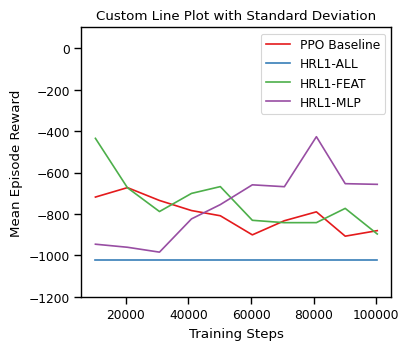

In [103]:
# Plot the line with standard deviation as error bars
fig = plt.figure(figsize=(4, 3.5))

# Plot each category separately
for i, cat in enumerate(tmp['exp'].unique()):
    subset = tmp[tmp['exp'] == cat]
    plt.plot(subset['step'], subset['train/mean_episode_reward'], color=plt.cm.Set1(i), label=experiments[cat])
    # plt.errorbar(subset['step'], subset['train/mean_episode_reward'], 
    #             yerr=subset['train/std_episode_reward'], fmt='-o',
    #             capsize=3, capthick=1, alpha=0.2, color=plt.cm.Set1(i)) 

plt.xlabel("Training Steps")
plt.ylabel("Mean Episode Reward")
plt.title("Custom Line Plot with Standard Deviation")
plt.ylim(-1200, 100)
plt.legend()
plt.show()


Text(0.5, 1.0, 'Training Entropy Loss')

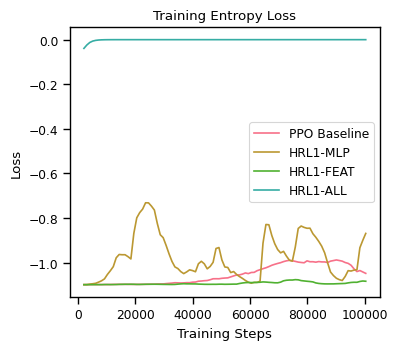

In [104]:
_t = df.loc[df['metric'] == "train/entropy_loss", :]
fig = plt.figure(figsize=(4, 3.5))
sns.lineplot(data=_t, x='step', y='smth_value', hue='label')
plt.xlabel("Training Steps")
plt.legend(title=None)
plt.ylabel("Loss")
# plt.yscale("log")
plt.title("Training Entropy Loss")
# plt.savefig("../project_milestone/figures/dqn_loss.png", dpi=300, bbox_inches='tight')